# **Kernel Eigenfaces**

## **Part 1**

### **Loading the Yale Face Database**

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Paths
train_folder = "Yale_Face_Database/training"
test_folder = "Yale_Face_Database/testing"

# Image size (resize if needed)
IMG_SIZE = (100, 100)  # Resize to 100x100 for simplicity

def load_images(folder):
    images = []
    labels = []
    label_dict = {}
    current_label = 0

    for filename in os.listdir(folder):
        if filename.endswith(".pgm"):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, IMG_SIZE).flatten()  # Flatten image
            
            images.append(img_resized)
            subject = filename.split('.')[0]  # Extract subject ID
            if subject not in label_dict:
                label_dict[subject] = current_label
                current_label += 1
            labels.append(label_dict[subject])

    return np.array(images), np.array(labels)

# Load training and testing data
X_train, y_train = load_images(train_folder)
X_test, y_test = load_images(test_folder)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (135, 10000)
Testing data shape: (30, 10000)


### **PCA Implementation**

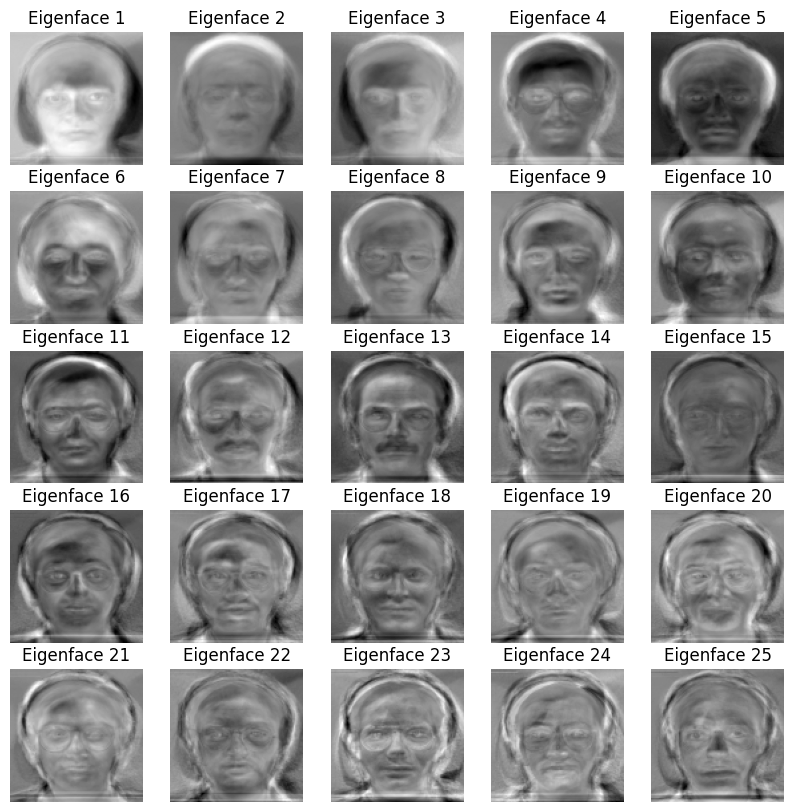

In [198]:
def pca(X, num_components):
    # Center the data
    mean_face = np.mean(X, axis=0)
    X_centered = X - mean_face

    # Compute the covariance matrix
    covariance_matrix = np.dot(X_centered, X_centered.T)

    # Solve eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # Sort eigenvectors by eigenvalues
    sorted_indices = np.argsort(-eigenvalues)
    eigenvectors = eigenvectors[:, sorted_indices]

    # Get top eigenfaces
    top_eigenvectors = eigenvectors[:, :num_components]
    top_eigenfaces = np.dot(X_centered.T, top_eigenvectors)

    # Normalize eigenfaces
    top_eigenfaces = top_eigenfaces / np.linalg.norm(top_eigenfaces, axis=0)

    return mean_face, top_eigenfaces

# Compute PCA
num_components = 25
mean_face, eigenfaces = pca(X_train, num_components)

# Display first 25 eigenfaces
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    face = eigenfaces[:, i].reshape(IMG_SIZE)
    ax.imshow(face, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Eigenface {i+1}")
plt.show()


### **Reconstruction PCA**

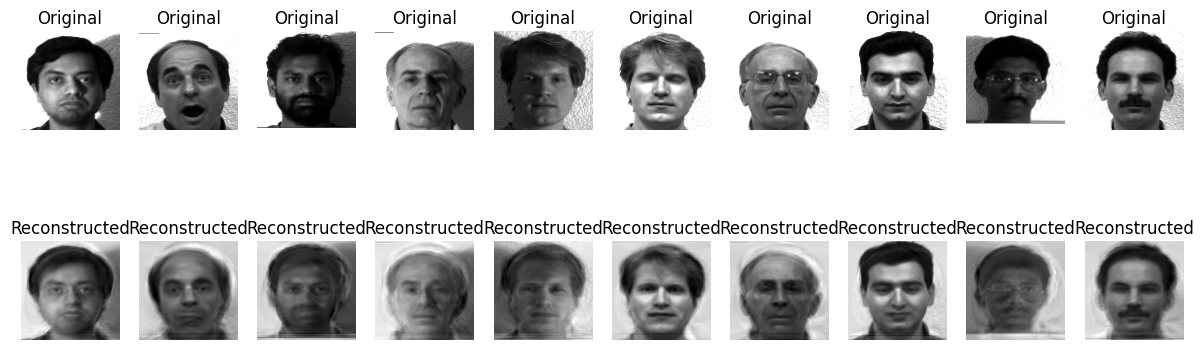

In [199]:
def reconstruct_images(X, mean_face, eigenfaces, num_components):
    X_centered = X - mean_face
    projections = np.dot(X_centered, eigenfaces[:, :num_components])
    reconstructed = np.dot(projections, eigenfaces[:, :num_components].T) + mean_face
    return reconstructed

# Reconstruct 10 random images
num_reconstructions = 10
indices = np.random.choice(X_train.shape[0], num_reconstructions, replace=False)
originals = X_train[indices]
reconstructed = reconstruct_images(originals, mean_face, eigenfaces, num_components)

# Plot original vs reconstructed
fig, axes = plt.subplots(2, num_reconstructions, figsize=(15, 5))
for i in range(num_reconstructions):
    axes[0, i].imshow(originals[i].reshape(IMG_SIZE), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")
    
    axes[1, i].imshow(reconstructed[i].reshape(IMG_SIZE), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed")
plt.show()


### **LDA**

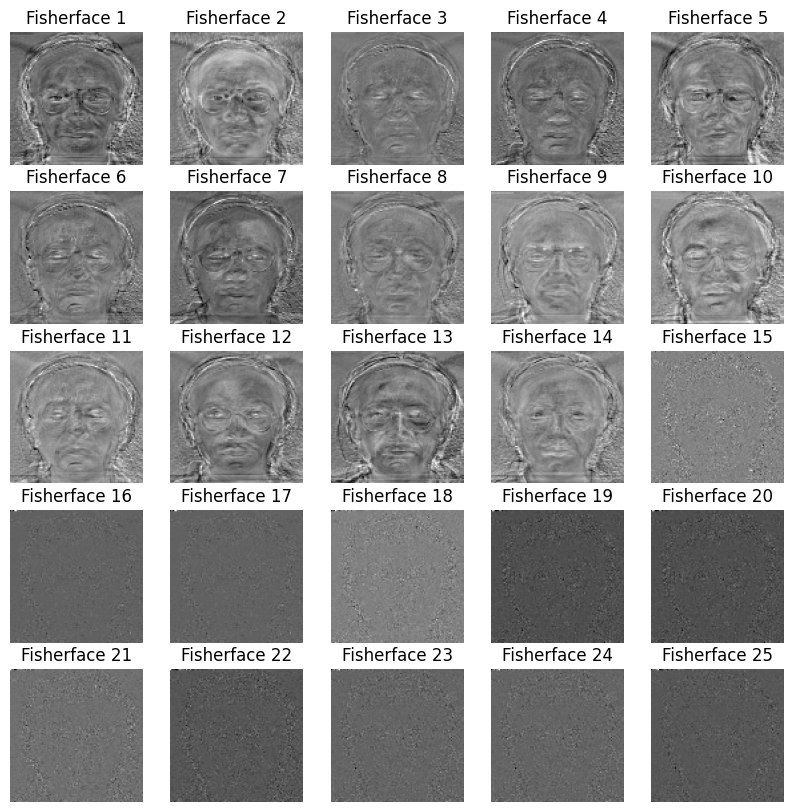

In [200]:
def lda(X, y, num_components):
    # Compute overall mean
    mean_overall = np.mean(X, axis=0)

    # Compute within-class and between-class scatter matrices
    Sw = np.zeros((X.shape[1], X.shape[1]))
    Sb = np.zeros((X.shape[1], X.shape[1]))
    
    for label in np.unique(y):
        X_class = X[y == label]
        mean_class = np.mean(X_class, axis=0)
        
        Sw += np.dot((X_class - mean_class).T, (X_class - mean_class))
        Sb += len(X_class) * np.outer(mean_class - mean_overall, mean_class - mean_overall)
    
    # Solve the generalized eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))
    sorted_indices = np.argsort(-eigenvalues.real)
    fisherfaces = eigenvectors[:, sorted_indices[:num_components]].real
    
    return fisherfaces

# Apply LDA
fisherfaces = lda(X_train, y_train, num_components)

# Display Fisherfaces
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    face = fisherfaces[:, i].reshape(IMG_SIZE)
    ax.imshow(face, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Fisherface {i+1}")
plt.show()





### **Reconstruction LDA**

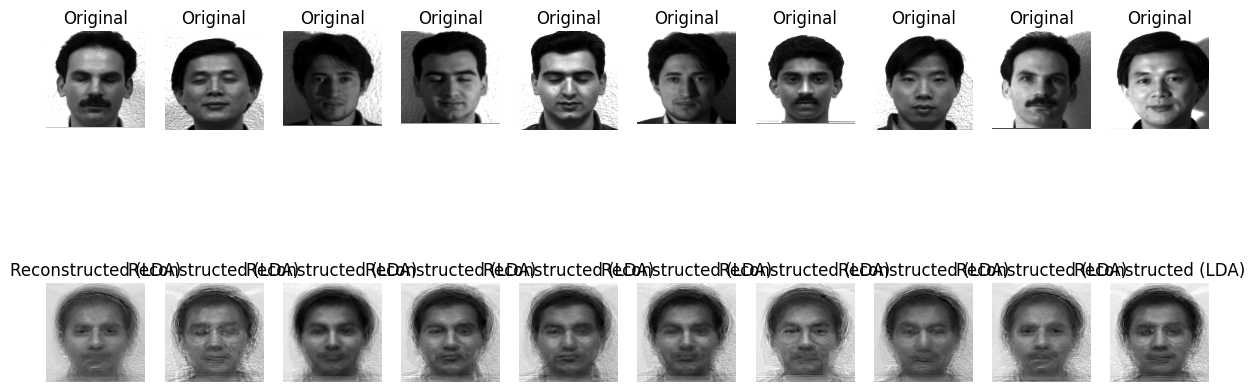

In [201]:
def reconstruct_lda(X, mean_face, fisherfaces, num_components):
    # Center the data
    X_centered = X - mean_face

    # Project to LDA space
    projections = np.dot(X_centered, fisherfaces[:, :num_components])

    # Reconstruct from LDA space
    reconstructed = np.dot(projections, fisherfaces[:, :num_components].T) + mean_face
    return reconstructed

# Reconstruct 10 images using LDA
indices = np.random.choice(X_train.shape[0], num_reconstructions, replace=False)
originals = X_train[indices]
reconstructed_images_lda = reconstruct_lda(originals, mean_face, fisherfaces, num_components=15)

# Plot Original vs Reconstructed (LDA)
fig, axes = plt.subplots(2, num_reconstructions, figsize=(15, 6))
for i in range(num_reconstructions):
    # Original Image
    axes[0, i].imshow(originals[i].reshape(IMG_SIZE), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Reconstructed Image
    axes[1, i].imshow(reconstructed_images_lda[i].reshape(IMG_SIZE), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed (LDA)")
plt.show()


## **Part 2**

### **accuracy function**

In [202]:
def compute_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total

### **PCA face recognition**

In [203]:
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score

def pca_projection(X_train, X_test, mean_face, eigenfaces, num_components):
    # Center the data
    X_train_centered = X_train - mean_face
    X_test_centered = X_test - mean_face

    # Project to PCA space
    X_train_pca = np.dot(X_train_centered, eigenfaces[:, :num_components])
    X_test_pca = np.dot(X_test_centered, eigenfaces[:, :num_components])
    
    return X_train_pca, X_test_pca

# Apply PCA
num_pca_components = 25
mean_face, eigenfaces = pca(X_train, num_pca_components)
X_train_pca, X_test_pca = pca_projection(X_train, X_test, mean_face, eigenfaces, num_pca_components)



# k-Nearest Neighbors Classification
def knn_classify(X_train_proj, y_train, X_test_proj, k=3):
    distances = cdist(X_test_proj, X_train_proj)  # Compute distances
    nearest_indices = np.argsort(distances, axis=1)[:, :k]
    y_pred = np.array([np.argmax(np.bincount(y_train[indices])) for indices in nearest_indices])
    return y_pred



# Classification and Accuracy
y_pred_pca = knn_classify(X_train_pca, y_train, X_test_pca, k=3)
accuracy_pca = compute_accuracy(y_test, y_pred_pca)
print(f"PCA Classification Accuracy: {accuracy_pca * 100:.2f}%")



PCA Classification Accuracy: 83.33%


### **LDA face recognition**

In [204]:
# LDA Projection on Original High-Dimensional Space
def lda_projection(X_train, X_test, mean_face, fisherfaces, num_components):
    # Center the data
    X_train_centered = X_train - mean_face
    X_test_centered = X_test - mean_face

    # Project to LDA space
    X_train_lda = np.dot(X_train_centered, fisherfaces[:, :num_components])
    X_test_lda = np.dot(X_test_centered, fisherfaces[:, :num_components])
    return X_train_lda, X_test_lda

# Step 1: Compute LDA
num_lda_components = 14  # C-1 components for 15 classes
mean_face = np.mean(X_train, axis=0)  # Mean face of the training set
#fisherfaces = lda(X_train, y_train, num_lda_components)  # LDA on high-dimensional space

# Step 2: Project Training and Testing Data to LDA Space
X_train_lda, X_test_lda = lda_projection(X_train, X_test, mean_face, fisherfaces, num_lda_components)

# Step 3: kNN Classification
y_pred_lda = knn_classify(X_train_lda, y_train, X_test_lda, k=3)

# Step 4: Compute Accuracy Manually
accuracy_lda = compute_accuracy(y_test, y_pred_lda)
print(f"LDA Classification Accuracy : {accuracy_lda * 100:.2f}%")


LDA Classification Accuracy : 96.67%


## **Part 3**

In [205]:
# # Normalize training and testing data
# X_train_mean = X_train.mean(axis=0)
# X_train_std = X_train.std(axis=0)

# X_train = (X_train - X_train_mean) / X_train_std
# X_test = (X_test - X_train_mean) / X_train_std

### **Kernel function**

In [242]:
def compute_kernel(X, Y=None, kernel_type='linear', degree=3, gamma=None, coef0=1):
    """
    Compute the kernel matrix for the given data and kernel type.
    If Y is None, computes the kernel matrix for X against itself.
    """
    if Y is None:
        Y = X  # Default to X if Y is not provided (training kernel)

    mean_face_X = np.mean(X, axis=0)
    X_centered = X - mean_face_X    

    mean_face_Y = np.mean(Y, axis=0)
    Y_centered = Y - mean_face_Y

    X = X_centered
    Y = Y_centered

    if kernel_type == 'linear':
        return np.dot(X, Y.T)  # Linear kernel: K(x, y) = x ⋅ y
    elif kernel_type == 'polynomial':
        return (np.dot(X, Y.T) + coef0) ** degree  # Polynomial kernel
    elif kernel_type == 'rbf':
        if gamma is None:
            gamma = 1 / X.shape[1]  # Default gamma value
        sq_dists = cdist(X, Y, metric='sqeuclidean')
        return np.exp(-gamma * sq_dists)  # RBF kernel: exp(-gamma * ||x - y||^2)
    else:
        raise ValueError(f"Unsupported kernel type: {kernel_type}")


### **Kernel PCA**

In [243]:
def kernel_pca(X_train, num_components, kernel_type='linear', degree=3, gamma=None, coef0=1):
    """
    Perform Kernel PCA on the given data.
    """
    # Step 1: Compute the kernel matrix
    K = compute_kernel(X_train, kernel_type=kernel_type, degree=degree, gamma=gamma, coef0=coef0)
    print("Kernel matrix (training):")
    print(K)
    # Step 2: Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K #- one_n @ K - K @ one_n + one_n @ K @ one_n

    # Step 3: Perform eigen decomposition on the centered kernel matrix
    eigenvalues, eigenvectors = np.linalg.eigh(K_centered)

    # Step 4: Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 5: Select the top eigenvectors
    top_eigenvectors = eigenvectors[:, :num_components]

    # Step 6: Project the data into the kernel PCA space
    X_kpca = np.dot(K_centered, top_eigenvectors)

    return X_kpca, eigenvalues[:num_components], top_eigenvectors

In [244]:
# Apply Kernel PCA
num_components = 25
gamma = 0.00001
type = 'polynomial'  # 'linear', 'polynomial', 'rbf'
degree = 2
coef0 = 0.001
X_train_kpca, eigenvalues_kpca, eigenvectors = kernel_pca(X_train, num_components, kernel_type=type, degree=degree, gamma=gamma, coef0=coef0)
print("Top eigenvalues from Kernel PCA:")
print(eigenvalues_kpca)


# To project testing data, we would need the kernel matrix between test and train:
def project_kernel(X_train, X_test, top_eigenvectors, kernel_type='rbf', degree=3, gamma=None, coef0=1):
    """
    Project test data into the kernel PCA space using the top eigenvectors.
    """
    K_test = compute_kernel(X_test, X_train, kernel_type=kernel_type, degree=degree, gamma=gamma, coef0=coef0)
    print("Kernel matrix (testing):")
    print(K_test)
    return np.dot(K_test, top_eigenvectors)

# Project Test Data
X_test_kpca = project_kernel(X_train, X_test, top_eigenvectors=eigenvectors[:, :num_components], kernel_type=type, degree= degree,gamma=gamma ,coef0=coef0)

# Perform Classification
y_pred_kpca = knn_classify(X_train_kpca, y_train, X_test_kpca, k=3)

# Compute Accuracy
accuracy_kpca = compute_accuracy(y_test, y_pred_kpca)
print(f"Kernel PCA Accuracy (RBF Kernel): {accuracy_kpca * 100:.2f}%")


Kernel matrix (training):
[[8.52447923e+14 8.81247501e+13 5.04971490e+13 ... 1.27737792e+11
  4.67143033e+11 4.28512278e+12]
 [8.81247501e+13 6.65957632e+14 5.21641031e+14 ... 1.80676675e+11
  3.60919577e+11 4.93716667e+10]
 [5.04971490e+13 5.21641031e+14 9.61660934e+14 ... 6.84261752e+10
  3.27170892e+12 3.89534328e+12]
 ...
 [1.27737792e+11 1.80676675e+11 6.84261752e+10 ... 1.29381016e+15
  6.75580999e+14 5.00073008e+14]
 [4.67143033e+11 3.60919577e+11 3.27170892e+12 ... 6.75580999e+14
  1.81206855e+15 1.06405028e+15]
 [4.28512278e+12 4.93716667e+10 3.89534328e+12 ... 5.00073008e+14
  1.06405028e+15 1.47386142e+15]]
Top eigenvalues from Kernel PCA:
[3.00043063e+16 2.03748242e+16 1.78056504e+16 1.14845968e+16
 1.02419342e+16 8.15930353e+15 7.10493217e+15 6.14032783e+15
 5.64386450e+15 5.15925270e+15 4.57185641e+15 4.19189015e+15
 4.02636283e+15 3.75444010e+15 3.36045925e+15 3.22628925e+15
 3.01844994e+15 2.76995968e+15 2.72336803e+15 2.60287107e+15
 2.48320963e+15 2.36978895e+15 2.337

In [237]:
# X_train_mean = X_train.mean(axis=0)
# X_train_std = X_train.std(axis=0)

# X_train = (X_train - X_train_mean) / X_train_std
# X_test = (X_test - X_train_mean) / X_train_std


### **Kernel LDA**

In [245]:
def kernel_lda(X_train, y_train, num_components, kernel_type='linear', degree=3, gamma=None, coef0=1):
    """
    Perform Kernel LDA on the given data.
    """
    # Step 1: Compute the kernel matrix
    K = compute_kernel(X_train, kernel_type=kernel_type, degree=degree, gamma=gamma, coef0=coef0)
    
    # Step 2: Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K #- one_n @ K - K @ one_n + one_n @ K @ one_n
    
    # Step 3: Compute within-class and between-class scatter matrices
    unique_classes = np.unique(y_train)
    Sw = np.zeros_like(K)
    Sb = np.zeros_like(K)
    mean_total = np.mean(K_centered, axis=0)

    for c in unique_classes:
        class_indices = np.where(y_train == c)[0]
        K_class = K_centered[class_indices]
        mean_class = np.mean(K_class, axis=0)

        # Between-class scatter
        Sb += len(class_indices) * np.outer(mean_class - mean_total, mean_class - mean_total)

        # Within-class scatter
        centered_class = K_class - mean_class
        Sw += centered_class.T @ centered_class

    # Step 4: Solve the generalized eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.pinv(Sw) @ Sb)

    # Step 5: Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(-eigenvalues.real)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Step 6: Select the top eigenvectors
    top_eigenvectors = eigenvectors[:, :num_components].real

    # Step 7: Project the data into the kernel LDA space
    X_klda = np.dot(K_centered, top_eigenvectors)

    return X_klda, eigenvalues[:num_components], top_eigenvectors


In [249]:
# Apply Kernel LDA
num_components = 25  # C - 1, where C is the number of classes
X_train_klda, eigenvalues_klda, top_eigenvectors = kernel_lda(X_train, y_train, num_components, kernel_type='rbf', gamma=0.001)

# Project test data into the Kernel LDA space
K_test = compute_kernel(X_test, X_train, kernel_type='rbf', gamma=0.001)
X_test_klda = np.dot(K_test, top_eigenvectors)

# Perform Classification
y_pred_klda = knn_classify(X_train_klda, y_train, X_test_klda, k=3)

# Compute Accuracy
accuracy_klda = compute_accuracy(y_test, y_pred_klda)
print(f"Kernel LDA Accuracy (RBF Kernel): {accuracy_klda * 100:.2f}%")



Kernel LDA Accuracy (RBF Kernel): 6.67%


###  **Classification and Comparison**

In [235]:
# Define a function for comparison
def compare_methods(X_train, y_train, X_test, y_test, num_components=25, kernel_types=['linear', 'polynomial', 'rbf'], degree=3, gamma=0.001):
    """
    Compare Simple PCA/LDA and Kernel PCA/LDA with different kernels.
    """
    results = []

    # Standard PCA
    mean_face, eigenfaces = pca(X_train, num_components)
    X_train_pca, X_test_pca = pca_projection(X_train, X_test, mean_face, eigenfaces, num_components)
    y_pred_pca = knn_classify(X_train_pca, y_train, X_test_pca, k=3)
    accuracy_pca = compute_accuracy(y_test, y_pred_pca)
    results.append(("PCA", "None", accuracy_pca))

    # Standard LDA
    fisherfaces = lda(X_train, y_train, num_components)
    X_train_lda, X_test_lda = lda_projection(X_train, X_test, mean_face, fisherfaces, num_components)
    y_pred_lda = knn_classify(X_train_lda, y_train, X_test_lda, k=3)
    accuracy_lda = compute_accuracy(y_test, y_pred_lda)
    results.append(("LDA", "None", accuracy_lda))

    # Kernel PCA with different kernels
    for kernel in kernel_types:
        X_train_kpca, eigenvalues_kpca, eigenvectors_kpca = kernel_pca(X_train, num_components, kernel_type=kernel, degree=degree, gamma=gamma)
        X_test_kpca = project_kernel(X_train, X_test, eigenvectors_kpca, kernel_type=kernel, degree=degree, gamma=gamma)
        y_pred_kpca = knn_classify(X_train_kpca, y_train, X_test_kpca, k=3)
        accuracy_kpca = compute_accuracy(y_test, y_pred_kpca)
        results.append(("Kernel PCA", kernel, accuracy_kpca))

    # Kernel LDA with different kernels
    for kernel in kernel_types:
        X_train_klda, eigenvalues_klda, eigenvectors_klda = kernel_lda(X_train, y_train, num_components, kernel_type=kernel, degree=degree, gamma=gamma)
        K_test = compute_kernel(X_test, X_train, kernel_type=kernel, degree=degree, gamma=gamma)
        X_test_klda = np.dot(K_test, eigenvectors_klda)
        y_pred_klda = knn_classify(X_train_klda, y_train, X_test_klda, k=3)
        accuracy_klda = compute_accuracy(y_test, y_pred_klda)
        results.append(("Kernel LDA", kernel, accuracy_klda))

    # Print results
    print(f"{'Method':<15}{'Kernel':<15}{'Accuracy':<10}")
    print("-" * 40)
    for method, kernel, accuracy in results:
        print(f"{method:<15}{kernel:<15}{accuracy * 100:.2f}%")


In [239]:
compare_methods(X_train, y_train, X_test, y_test, num_components=25, kernel_types=['linear', 'polynomial', 'rbf'], degree=3, gamma=0.001)


Kernel matrix (training):
[[ 7518.82106444  3520.84490054  3878.90674832 ...  -560.10703809
   -471.6114922   -159.13959661]
 [ 3520.84490054  8997.99378631  8267.43012494 ...   411.88557538
    368.8532664    623.9773912 ]
 [ 3878.90674832  8267.43012494 11265.55127414 ...   360.44550906
    303.40273029    64.26337022]
 ...
 [ -560.10703809   411.88557538   360.44550906 ...  7115.91545079
   5243.08826452  4282.24216731]
 [ -471.6114922    368.8532664    303.40273029 ...  5243.08826452
  10105.54696459  6303.58954951]
 [ -159.13959661   623.9773912     64.26337022 ...  4282.24216731
   6303.58954951  8236.43396611]]
Kernel matrix (testing):
[[ 3.58812687e+03  7.04163687e+03  8.34401046e+03 ...  2.11849477e+02
   6.47990635e+01 -6.06226622e+01]
 [ 5.00707915e+03  1.61550086e+02  2.20723035e+02 ... -2.03448782e+03
  -8.14567260e+02 -1.40803458e+03]
 [-4.82194981e+02  1.40934521e+02 -1.00231672e+03 ...  1.07702879e+03
   8.58122043e+02  8.38420038e+02]
 ...
 [-2.87929234e+02  4.37361121